# Moon Visibility Calculations

This file can generate a set of moon parameters over a 24 hour period for a given day, and save this as a CSV file.

This data can then be displayed in various formats. Data can also be read in from a file and displayed.

It can also convert sighting data in various formats into a standardised file for use in other notebooks.

## Imports

In [115]:
#Standard imports
import time
from datetime import datetime
from zoneinfo import ZoneInfo
from enum import Enum

#Utility imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#Astropy imports
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import Angle, EarthLocation, Longitude, Latitude
from astropy.coordinates import get_body, AltAz, solar_system_ephemeris
from astropy.constants import R_earth

#Skyfield imports
from skyfield import api,almanac
ts = api.load.timescale()
eph = api.load('de430_1850-2150.bsp')

#Cartopy imports
import cartopy.crs as ccrs
from cartopy import feature as cfeature

#Geovista imports
import geovista as gv

#Other imports
from suncalc import get_times
from astroplan import Observer
from timezonefinder import TimezoneFinder
ZoneFinder = TimezoneFinder()

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Options

In [116]:
class modes(Enum):
    Generate = 0 #Calculate and save parameters for a specific date
    Display = 1 #Display previously calculated data
    Process = 2 #Process data files

MODE = modes.Display #Set the mode here

#Generation and display options
OBSERVATION_DATE = Time("2023-12-14")
MIN_LAT = 48 #-60
MAX_LAT = 60
MAX_LAT = 58.5
MIN_LON = -8 #-180
MAX_LON = 2 #180
NO_OF_POINTS = 50

OBSERVATION_DATE = Time("2023-03-22")
MIN_LAT = -60
MAX_LAT = 60
MIN_LON = -180
MAX_LON = 180
NO_OF_POINTS = 100

#Display options
CONTOUR_PLOT = True #Plot a contour of visibility
GLOBE_PLOT = False #Plot visibility on a globe
GLOBES_PLOT = False #Plot visibility on globes
GLOBE3D_PLOT = True #3D globe plot


#Calculate parameters using sighting data from files and save
#WARNING - this will overwrite existing "with_params.csv" files
PROCESS_ICOUK = False
PROCESS_ICOP = False
PROCESS_ALREFAY = False
PROCESS_SCHAEFER_ODEH = False
PROCESS_YALLOP = False
PROCESS_ICOP23 = False
COMBINE_FILES = False #Combine all processed files into one

# Calculating parameters

## Time and time zone calculations

In [117]:
def get_time_zone(latitude,longitude):
    #Returns an astropy timedelta object with correct UTC offset
    zone_name = ZoneFinder.timezone_at(lat=latitude,lng=longitude)
    utc_offset = datetime.now(ZoneInfo(zone_name)).utcoffset().total_seconds()
    return TimeDelta(utc_offset*u.second)

def get_best_obs_time(sunset, moonset):
    #Gets best time using Bruin's method

    sunset = Time(sunset, scale='utc')
    moonset = Time(moonset, scale='utc')

    #Note -  some slight discrepancy between T_S + 4/9 LAG and below method
    #lag = sunset.to_value("jd") - moonset.to_value("jd")
    #best_time = sunset + (4/9)*TimeDelta(lag, format="jd")
    #return best_time

    #Bruin best time Tb = (5 Ts +4 Tm)/ 9
    best_time = (1/9)*(5*sunset.to_value("jd")+4*moonset.to_value("jd"))
    return Time(best_time, format="jd", scale='utc')


## Calculating sunset and moonset

In [118]:
def get_sunset_time(obs_date,lat, lon,sunrise=False): 
    #Gets sunset time using skyfield (MEDIUM)
    location = api.wgs84.latlon(lat,lon)

    t0 = ts.from_astropy(obs_date)
    t1 = ts.from_astropy(obs_date+TimeDelta(1,format="jd"))

    f = almanac.sunrise_sunset(eph, location)
    t, y = almanac.find_discrete(t0, t1, f)

    sunsets = t[y==sunrise]

    #MAY NO LONGER BE NEEDED?
    if len(sunsets) == 0: #If no sunset found, add another day to search forward
        t1 = ts.from_astropy(obs_date+TimeDelta(2,format="jd"))
        f = almanac.sunrise_sunset(eph, location)
        t, y = almanac.find_discrete(t0, t1, f)
        sunsets = t[y==sunrise]

    try:
        sunset = sunsets.utc_iso()[0]

    except:
        print(f"Error calculating sunset for Longitude: {lon} Latitude: {lat}.")
        sunset = obs_date

    return sunset

def get_moonset_time(obs_date,lat, lon,moonrise=False):
    #Gets moonset time using skyfield (MEDIUM)
    location = api.wgs84.latlon(lat,lon)

    t0 = ts.from_astropy(obs_date)
    t1 = ts.from_astropy(obs_date+TimeDelta(1,format="jd"))

    f = almanac.risings_and_settings(eph, eph['Moon'], location)
    t, y = almanac.find_discrete(t0, t1, f)

    moonsets = t[y==moonrise]

    #MAY NO LONGER BE NEEDED?
    if len(moonsets) == 0: #If no moonset found, add another day to search forward
        t1 = ts.from_astropy(obs_date+TimeDelta(2,format="jd"))
        f = almanac.risings_and_settings(eph, eph['Moon'], location)
        t, y = almanac.find_discrete(t0, t1, f)
        moonsets = t[y==moonrise]

    try:
        moonset = moonsets.utc_iso()[0]

    except:
        print(f"Error calculating moonset for Longitude: {lon} Latitude: {lat}.")
        moonset = obs_date

    return moonset


def get_sun_moonset_date_local(d,lat,lon):
    #Get time difference between UTC and local
    local_time_diff = get_time_zone(latitude=lat,longitude=lon)
    twelve_hours = TimeDelta(0.5,format="jd")

    #If west of 0 deg longitude, search from DD-1/MM/YYYY 12:00 LOCAL
    if lon < 0:
        #Create object that is  DD-1/MM/YYYY 12:00 LOCAL
        local_midday_day_before = d - twelve_hours

        #SUBTRACT time diff to go from local to UTC
        utc_search_time = local_midday_day_before - local_time_diff + TimeDelta(1,format="jd")

    #If east of 0 deg longitude, search from DD/MM/YYYY 00:00 UTC
    elif lon >= 0:
        #Create object that is  DD/MM/YYYY 12:00 LOCAL
        local_midday_day_of = d + twelve_hours

        #SUBTRACT time diff to go from local to UTC
        utc_search_time = local_midday_day_of - local_time_diff

    return utc_search_time

def get_sunset_moonset_local(d,lat,lon):

    sun_moonset_date = get_sun_moonset_date_local(d,lat,lon)
    sunset = get_sunset_time(sun_moonset_date,lat,lon) #Use skyfield
    moonset = get_moonset_time(sun_moonset_date,lat,lon)

    if moonset < sunset: # Use sunrise and moonrise
        sunset = get_sunset_time(sun_moonset_date-TimeDelta(1,format="jd"),lat,lon,sunrise=True) #Use skyfield
        moonset = get_moonset_time(sun_moonset_date-TimeDelta(1,format="jd"),lat,lon,moonrise=True)

    return sunset, moonset

## Calculating q-value

In [119]:
def get_q_value(alt_diff, width):
    #Calculate q-test value using Yallop formula

    ARCV = alt_diff
    W = width.arcmin
    q = (ARCV.deg - (11.8371 - 6.3226*W + 0.7319*W**2 - 0.1018*W**3 )) / 10

    return q

## Moon parameters

In [120]:
def get_geocentric_parallax(object_position,distance):
    #Gets geocentric parallax of object
    #sin(p) = (a / r) sin(z')
    r = distance
    a = R_earth
    z = object_position.zen
    p = np.arcsin((a/r)*np.sin(z.radian))
    return Angle(p)

def get_new_moon_date(obs_date):
    #Gets date of last new moon
    one_month_ago = obs_date - TimeDelta(30,format="jd")
    t0 = ts.from_astropy(one_month_ago)
    t1 = ts.from_astropy(obs_date)
    t, y = almanac.find_discrete(t0, t1, almanac.moon_phases(eph))

    new_moon = t[y==0][-1] #Get most recent new moon
    #new_moon_date = new_moon.utc_datetime().replace(hour=0, minute=0,second=0)
    return Time(new_moon.utc_datetime())

def get_moon_age(obs_date):
    #Gets age of moon as a number of days
    last_new_moon = get_new_moon_date(obs_date)
    moon_age = obs_date-last_new_moon
    return moon_age.jd

In [121]:
def get_moon_params(d,lat,lon,local_dates=False,display=False):
    #This calculates the q-test value and other moon params

    #Create coordinates object
    #Latitude is -90 to 90
    latitude = Latitude(lat*u.deg)
    #Longitude is -180 to +180
    longitude = Longitude(lon*u.deg,wrap_angle=180*u.deg)
    coords=EarthLocation.from_geodetic(lon=longitude,lat=latitude)

    #Calculate sunset and moonset time

    if local_dates:
        sunset, moonset = get_sunset_moonset_local(d,lat,lon)
    else:
        sunset = get_sunset_time(d,lat,lon) #Use skyfield
        moonset = get_moonset_time(d,lat,lon)
    
    best_obs_time = get_best_obs_time(sunset, moonset)
    #Calculate best observation time if no time given
    d = best_obs_time

    #Get positions of Moon and Sun
    with solar_system_ephemeris.set('builtin'):
        moon = get_body('moon',d,coords)
        sun = get_body('sun',d,coords)
        earth = get_body('earth',d,coords)

    #Get moon and sun positions in alt/az coords
    moon_altaz = moon.transform_to(AltAz(obstime=d,location=coords))
    sun_altaz = sun.transform_to(AltAz(obstime=d,location=coords))

    #Get moon age
    MOON_AGE = get_moon_age(d)

    #Get distance to Moon from Sun and Earth
    MOON_EARTH_DIST = moon.separation_3d(earth)
    DIST = moon.separation_3d(sun)

    #Calculate angular separation of moon and sun
    ARCL = moon.separation(sun)

    #Find alt/az difference
    ARCV = np.abs(sun_altaz.alt - moon_altaz.alt)

    #Calculate geocentric parallax
    parallax = get_geocentric_parallax(moon_altaz, MOON_EARTH_DIST)

    #Calculate moon altitude
    h = moon_altaz.alt

    #Calculate illumination
    ILLUMINATION = 0.5*(1 - np.cos(ARCL.radian))

    #Calculate moon semi-diameter
    SD = 0.27245*parallax

    #Calculate topocentric moon semi-diameter and topcentric width
    SD_dash = SD*(1 + np.sin(h.radian)*np.sin(parallax.radian))
    W_dash = SD_dash*(1 - np.cos(ARCL.radian))

    #Calculate topocentric q-test value
    q_dash = get_q_value(ARCV, W_dash)

    #Extra stuff

    #Calculate DAZ
    DAZ = sun_altaz.az - moon_altaz.az

    #Calculate moon semi-diameter and width
    W = SD*(1 - np.cos(ARCL.radian))

    #Calculate q-test value
    q = get_q_value(ARCV, W)

    LAG = (Time(moonset).to_value("jd")-Time(sunset).to_value("jd"))*24*60

    if display:
        print(f"OBS LAT: {lat}. LON: {lon}")
        print(f"OBS TIME: {d.to_datetime().hour}:{d.to_datetime().minute}")
        print(f"BEST OBS TIME: {best_obs_time.to_datetime().hour}:{best_obs_time.to_datetime().minute}")
        print(f"DATE: {d.to_value('datetime')}")
        print(f"JULIAN DATE: {d.to_value('jd')}")
        print(f"MOON AGE: {round(MOON_AGE,3)}")
        print(f"MOONSET: {moonset}")
        print(f"SUNSET: {sunset}")
        print(f"LAG: {LAG:.5} mins") #Lag time
        print(f"MOON ALT: {moon_altaz.alt:.4}. AZ: {moon_altaz.az:.4}")
        print(f"SUN ALT: {sun_altaz.alt:.4}. AZ: {sun_altaz.az:.4}")
        print(f"EARTH-MOON DIST: {MOON_EARTH_DIST:.2}")
        print(f"SUN-MOON DIST: {DIST:.2}")
        print(f"ARCL: {ARCL:.3}")
        print(f"ARCV: {ARCV:.3}")
        print(f"DAZ: {DAZ:.3}")
        print(f"PARALLAX: {parallax.arcmin:.3} arcmin")
        print(f"ILLUMINATION: {ILLUMINATION:.3}")
        print(f"h: {h:.3}")
        print(f"W: {W.arcmin:.4} arcmin")
        print(f"W': {W_dash.arcmin:.4} arcmin")
        print(f"q(W): {q:.6}")
        print(f"q(W'): {q_dash:.6}")

    return np.round([d.to_value('jd'),
            lat,
            lon,
            round(MOON_AGE,3),
            Time(sunset).to_value("jd"),
            Time(moonset).to_value("jd"),
            LAG,
            moon_altaz.alt.deg,
            moon_altaz.az.deg,
            sun_altaz.alt.deg,
            sun_altaz.az.deg,
            MOON_EARTH_DIST.au,
            DIST.au,
            ARCL.deg,
            ARCV.deg,
            DAZ.deg,
            ILLUMINATION,
            parallax.arcmin,
            W.arcmin,
            W_dash.arcmin,
            q,
            q_dash],decimals=5)

# Generating parameters

In [122]:
cols = ["Date", "Latitude", "Longitude", "Moon Age",
            "Sunset", "Moonset", "Lag", 
            "Moon Alt", "Moon Az", "Sun Alt", "Sun Az",
            "Moon-Earth Dist", "Sun-Moon Dist",
            "ARCL", "ARCV", "DAZ",
            "Illumination", "Parallax",
            "W", "W'", "q", "q'",
            "Cloud Level", "Seen", "Method", "Methods"]

def yallop_to_binary(q_values):
    quantified_q = np.empty((q_values.size),dtype=str)
    quantified_q[q_values > 0.216] = "Seen" #A Easily visible
    quantified_q[np.logical_and(0.216 >= q_values, q_values > -0.014)] = "Seen" #B Visible under perfect conditions
    quantified_q[np.logical_and(-0.014 >= q_values, q_values > -0.160)] = "Seen" #C May need optical aid to find crescent
    quantified_q[np.logical_and(-0.160 >= q_values, q_values > -0.232)] = "Not_seen" #D Will need optical aid to find crescent
    quantified_q[np.logical_and(-0.232 >= q_values, q_values > -0.293)] = "Not_seen" #E Not visible with a telescope ARCL ≤ 8·5°
    quantified_q[-0.293 >= q_values] = "Not_seen" #F Not visible, below Danjon limit, ARCL ≤ 8°
    return quantified_q

def generate_parameters(date,min_lat, max_lat, min_lon, max_lon,no_of_points):
    print("Running")
    num_of_rows = no_of_points*no_of_points
    data = pd.DataFrame(index=np.arange(0, num_of_rows), columns=cols[0:-4])
    data.index.name="Index"

    lat_arr = np.linspace(min_lat, max_lat, no_of_points)
    lon_arr = np.linspace(min_lon, max_lon, no_of_points)

    start = time.time()
    position = 0
    for i, latitude in enumerate(lat_arr):
        lap = time.time()
        print(f"Calculating latitude {round(lat_arr[i],2)} at time={round(lap-start,2)}s")
        for j, longitude in enumerate(lon_arr):
            params = get_moon_params(date,latitude,longitude,True)
            data.loc[position] = params
            position += 1

    #Calculate seen/not seen for q-values
    q_values = data["q'"].astype("float")
    quantified_q = yallop_to_binary(q_values)
    data["Seen"] = quantified_q
    data["Source"] = np.full(data.shape[0],"GENERATED")
        
    data.to_csv(f'../Data/Generated/{date.to_datetime().date()} LAT {min_lat} {max_lat} LON {min_lon} {max_lon} {no_of_points}x{no_of_points}.csv')

    print(f"Total time: {round(time.time()-start,2)}s")

# Generating grid of parameters 

In [123]:
if MODE == modes.Generate:
    generate_parameters(OBSERVATION_DATE,MIN_LAT,MAX_LAT,MIN_LON,MAX_LON,NO_OF_POINTS)

# Displaying visibility

In [124]:
if MODE != modes.Process:
    file_path = f'../Data/Generated/{OBSERVATION_DATE.to_datetime().date()} LAT {MIN_LAT} {MAX_LAT} LON {MIN_LON} {MAX_LON} {NO_OF_POINTS}x{NO_OF_POINTS}'
    generated_params = pd.read_csv(file_path+'.csv')
    lat_arr = np.linspace(MIN_LAT, MAX_LAT, NO_OF_POINTS)
    lon_arr = np.linspace(MIN_LON, MAX_LON, NO_OF_POINTS)

    yallop_qval = generated_params["q'"].to_numpy(dtype=float)
    yallop_qval = np.reshape(yallop_qval,(len(lat_arr),len(lon_arr))) #Reshape to square

## Contour plot

In [125]:
def plot_contour(obs_date,lat_arr,long_array,q_val):
    #Plots moon visibility across a world map
    x, y = np.meshgrid(long_array,lat_arr,indexing='xy')
    plt.figure(figsize=(9,5))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    #ax.world()

    #custom colormap created, red to green 6 bins
    colors = [(1, 0, 0),(1,1,0), (0, 1, 0)]
    #colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']
    colors = ['#ca0020','#f4a582','#f7f7f7','#92c5de','#0571b0']
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=6)

    cs = plt.contourf(x, y , q_val, levels = [-0.293,-0.232, -0.160, -0.014, +0.216],
                       alpha=0.6, cmap=custom_cmap ,extend='both')

    #cs = plt.contourf(x, y , q_val,alpha=0.6, cmap=custom_cmap ,extend='max')

    plt.colorbar(cs,label='q-value',shrink=0.8)
    nm = cs.legend_elements()[0][1:]
    lbl = ['I(I)', 'I(V)', 'V(F)', 'V(V)', 'V']
    plt.legend(nm, lbl, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(lbl),fontsize=12)

    if -np.min(lon_arr)+ np.max(lon_arr) ==360:
        plt.ylim(-90,90)
        plt.xlim(-180,180)
    else:
        ax.set_extent((np.min(lon_arr), np.max(lon_arr),np.min(lat_arr), np.max(lat_arr)),crs=ccrs.PlateCarree())

    title_date = obs_date.to_datetime().date()
    #plt.title(f"Global moon visibility at best time ({title_date})")
    plt.tight_layout()
    plt.savefig(f"../Graphs/Global moon visibility at best time ({title_date}).png",dpi=200)
    plt.show()

## Globe plot

In [126]:
def plot_globe(obs_date,lat_arr,long_array,q_val):
    #Plots moon visibility across a globe

    #Set centre of globe
    PLOT_CENTRE = [0,0]

    x, y = np.meshgrid(long_array,lat_arr,indexing='xy')
    plt.figure(figsize=(9,5))


    ax = plt.axes(projection=ccrs.Orthographic(*PLOT_CENTRE))

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

    ax.set_global()
    ax.coastlines()
    #ax.world()

    crs = ccrs.PlateCarree()

    #custom colormap created, red to green 6 bins
    colors = [(1, 0, 0),(1,1,0), (0, 1, 0)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=6)

    cs = plt.contourf(x, y , q_val, levels = [-0.293,-0.232, -0.160, -0.014, +0.216],
                       alpha=0.6, cmap=custom_cmap ,extend='max',transform=crs)

    plt.colorbar(cs)
    nm = cs.legend_elements()[0]
    lbl = ['I(I)', 'I(V)', 'V(F)', 'V(V)', 'V']
    plt.legend(nm, lbl, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(lbl))

    title_date = obs_date.to_datetime().date()
    plt.title(f"Global moon visibility at best time ({title_date})")
    plt.show()

## Globes plot

In [127]:
def plot_globes(obs_date,lat_arr,long_array,q_val):
    #Plots moon visibility across a globe at four views

    #Array of centers
    PLOT_CENTRE_ARR = [[0,0],[90,0],[180,0],[-90,0]]

    x, y = np.meshgrid(long_array,lat_arr,indexing='xy')
    fig = plt.figure(layout='constrained')

    colors = [(1, 0, 0),(1,1,0), (0, 1, 0)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=6)

    for i in range(len(PLOT_CENTRE_ARR)):
        ax = fig.add_subplot(2,2,i+1,projection=ccrs.Orthographic(*PLOT_CENTRE_ARR[i]))

        ax.add_feature(cfeature.OCEAN, zorder=0)
        ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
        ax.set_global()
        crs = ccrs.PlateCarree()

        # plot discontinuity line between 180,-90 to 180,90
        ax.plot([180, -90], [180, 90], linestyle='dashed',transform=crs,
                linewidth=5) #doesnt work

        cs = ax.contourf(x, y , q_val, levels = [-0.293,-0.232, -0.160, -0.014, +0.216],
                      alpha=0.6, cmap=custom_cmap ,extend='max',transform=crs)


    fig.colorbar(cs, ax=fig.axes, shrink=0.9)
    nm = cs.legend_elements()[0]
    lbl = ['I(I)', 'I(V)', 'V(F)', 'V(V)', 'V']
    fig.legend(nm, lbl, loc='upper center', bbox_to_anchor=(0.5, -0.05)
               , ncol=len(lbl))

    title_date = obs_date.to_datetime().date()
    plt.suptitle(f"Global moon visibility at best time ({title_date})")
    plt.savefig(f"../Graphs/Global moon visibility at best time globes ({title_date}).png",dpi=200)
    plt.show()

## 3D Globe plot

In [128]:
def plot_globe3D(obs_date, lat_arr,long_arr, q_val):
    #Plots moon visibility across a 3D globe
    #conda install -c conda-forge geovista

    x, y = np.meshgrid(long_arr,lat_arr,indexing='xy')
    mesh = gv.Transform.from_2d(x, y, data=q_val,radius=1.0)

    colors = [(1, 0, 0),(1,1,0), (0, 1, 0)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=6)

    plotter=gv.GeoPlotter()

    #Create colourmap
    yallop_annotations = {
    1: 'I(I)',
    2: 'I(V)',
    3: 'V(F)',
    4: 'V(V)',
    5: 'V',
    6: 'X'}

    sargs = dict(title="q-value",
                 interactive=True,
                 n_labels=6,
                 italic=True,
                 font_family="times",
                 title_font_size=22,
                 label_font_size=22)

    plotter.add_mesh(mesh, show_edges=False,
                     annotations = yallop_annotations,
                     clim=[-0.293,+0.216],
                     cmap=custom_cmap,
                     scalar_bar_args=sargs,
                     below_color= [1.0, 0.0, 0.0, 1.0],
                     above_color= [0.0, 1.0, 0.0, 1.0],
                     opacity=0.5)

    plotter.add_base_layer(texture=gv.natural_earth_1(),opacity=1)
    #plotter.add_coastlines(resolution="10m",opacity=1)

    plotter.view_xy()
    plotter.add_axes()
    title_date = obs_date.to_datetime().date()
    plotter.add_title(f"Global moon visibility at best time ({title_date})",font="arial",font_size=12)
    #plotter.export_obj(f"Globes\\{title_date} {len(long_arr)}x{len(long_arr)}.obj")
    plotter.show(jupyter_backend='trame')

# Plot display

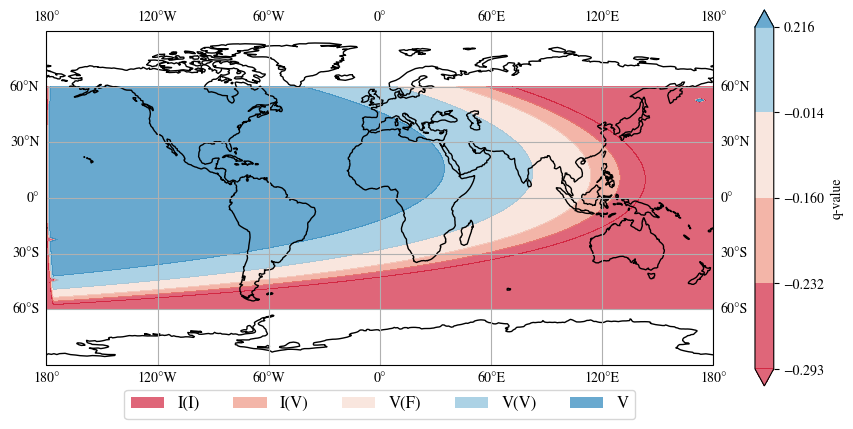

In [129]:
if MODE != modes.Process and CONTOUR_PLOT:
    plot_contour(OBSERVATION_DATE,lat_arr, lon_arr, yallop_qval)

In [130]:
if MODE != modes.Process and GLOBE_PLOT:
    plot_globe(OBSERVATION_DATE,lat_arr, lon_arr, yallop_qval)

In [131]:
if MODE != modes.Process and GLOBES_PLOT:
    plot_globes(OBSERVATION_DATE,lat_arr, lon_arr, yallop_qval)

In [132]:
if MODE != modes.Process and GLOBE3D_PLOT:
    plot_globe3D(OBSERVATION_DATE,lat_arr, lon_arr, yallop_qval)

Widget(value="<iframe src='http://localhost:61716/index.html?ui=P_0x1d370947dd0_0&reconnect=auto' style='width…

# Processing data from files

## General processing functions

In [133]:
def select_seen(method):
    #Converts method into binary seen/not_seen
    if method == "Not_seen":
        return "Not_seen"
    elif method == "Seen_ccd":
        return "Seen"
    elif method == "Seen_telescope":
        return "Seen"
    elif method == "Seen_binoculars":
        return "Seen"
    elif method == "Seen_eye":
        return "Seen"
    else:
        print(f"Error with {method}")
        return -1

def cloud_replace(cloud_text):
    #Converts cloud description to number
    cloud_text = cloud_text.lower()
    if cloud_text == "clear":
        return 0
    elif cloud_text == "rainy":
        return 0.5
    elif cloud_text == "partly_cloudy" or cloud_text == "partly cloudy":
        return 0.5
    elif cloud_text == "totally_cloudy" or cloud_text == "totally cloudy":
        return 1
    else:
        print(f"Error with {cloud_text}")
        return -1
    
def select_method_array(method):
    #Converts method to all possible methods
    methods = []
    if method == "Not_seen":
        methods = ["Not_seen"]
    elif method == "Seen_ccd":
        methods = ["Seen_ccd"]
    elif method == "Seen_telescope":
        methods = ["Seen_telescope", "Seen_ccd"]
    elif method == "Seen_binoculars":
        methods = ["Seen_binoculars", "Seen_telescope", "Seen_ccd"]
    elif method == "Seen_eye":
        methods = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd"]
    return ";".join(methods)

## Selecting methods from files

In [134]:
def select_method_ICOUK(row_seen,raw_method):
    if row_seen == "Not_seen":
        return "Not_seen"
    elif raw_method == "Naked-eye":
        return "Seen_eye"
    elif raw_method == "Binoculars":
        return "Seen_binoculars"
    elif raw_method == "Naked-eye_and/or_Binoculars":
        return "Seen_eye"
    elif raw_method == "Binoculars_and_Naked-eye":
        return "Seen_eye"
    elif raw_method == "Naked-eye_and_Binoculars":
        return "Seen_eye"
    else:
        print(f"Error with {raw_method}")
        return -1

def select_method_ICOP(row_seene,row_seenb,row_seent,row_seenc):
    if row_seene:
        return "Seen_eye"
    elif row_seenb:
        return "Seen_binoculars"
    elif row_seent:
        return "Seen_telescope"
    elif row_seenc:
        return "Seen_ccd"
    else:
        return "Not_seen"
    
def select_method_alrefay(raw_method):
    raw_method = raw_method.strip()
    if raw_method == "N":
        return "Seen_eye"
    elif raw_method == "T":
        return "Seen_telescope"
    elif raw_method == "Not_seen":
        return "Not_seen"
    else:
        print(f"Error with {raw_method}")
        return -1
    
def select_method_schaefer(vis):
    vis = vis.strip()
    if vis == "I": #Invisible with eye
        return "Not_seen"
    if vis == "I(I)": #Invisible with eye, invisible with telescope and binoculars
        return "Not_seen"
    elif vis == "I(B)" : #Invisible with eye, visible with binoculars
        return "Seen_binoculars"
    elif vis == "I(T)": #Invisible with eye, visible with telescope
        return "Seen_telescope"
    elif vis == "I(V)": #Invisible with eye, visible with either binoculars or telescope
        return "Seen_telescope" #Vague
    elif vis == "V(F)": #Visible with eye, after locating with visual aid
        return "Seen_eye"
    elif vis == "V(T)": #Visible with eye, visible with telescope
        return "Seen_eye"
    elif vis == "V(B)": #Visible with eye, visible with binoculars
        return "Seen_eye"
    elif vis == "V(V)": #Visible with eye, visible with either binoculars or telescope
        return "Seen_eye"
    elif vis == "V": #Visible
        return "Seen_eye"
    else:
        print(f"Error with {vis}")
        return -1

def select_method_ICOP23(row_seene,row_seenb,row_seent,row_seenc):
    if row_seene == "seen":
        return "Seen_eye"
    elif row_seenb == "seen":
        return "Seen_binoculars"
    elif row_seent == "seen":
        return "Seen_telescope"
    elif row_seenc == "seen":
        return "Seen_ccd"
    else:
        return "Not_seen"

In [135]:
def process_file(source, source_file):
    #Reads in data from a file, calculates moon params then saves
    raw_data = pd.read_csv(source_file)

    num_of_rows = raw_data.shape[0]

    data = pd.DataFrame(index=np.arange(0, num_of_rows), columns=cols)
    data.index.name="Index"

    for i, row in raw_data.iterrows():

        if source == "ICOUK": #ICOUK Data
            row_date = Time(datetime.strptime(row["Date"], "%d-%b-%y"))
            row_lat = float(row["Lat"])
            row_lon = float(row["Lon"])
            row_seen = row["Seen?"]
            raw_method = row["Method"]
            row_method = select_method_ICOUK(row_seen,raw_method)
            row_methods = select_method_array(row_method)
            row_cloud = cloud_replace(row["Clouds"])
            new_data = get_moon_params(row_date,row_lat,row_lon)
        
        elif source == "ICOP":
            row_date = Time(datetime.strptime(row["Date"], "%d/%m/%Y"))
            row_lat = float(row["lat"])
            row_lon = float(row["long"])
            row_seene = row["y_eye"]
            row_seenb = row["y_bino"]
            row_seent = row["y_tele"]
            row_seenc = row["y_ccd"]
            row_method = select_method_ICOP(row_seene,row_seenb,row_seent,row_seenc)
            row_seen = select_seen(row_method)
            row_methods = select_method_array(row_method)
            row_cloud = cloud_replace(row["x_sky"])
            new_data = get_moon_params(row_date,row_lat,row_lon)
        
        elif source=="ALREFAY":
            row_date = Time(datetime.strptime(row["Date"], " %Y/%m/%d"))
            row_lat = float(row["Lat."])
            row_lon = float(row["Long."])
            means = row["Means"]
            row_method = select_method_alrefay(means)
            row_seen = select_seen(row_method)
            row_methods = select_method_array(row_method)
            row_cloud = 0 #All clear weather measurements
            new_data = get_moon_params(row_date,row_lat,row_lon)
        
        elif source=="SCHAEFER-ODEH":
            date_text = row["Sight Date Best Time"].strip()[0:10]
            if date_text[2] == "-":
                row_date = Time(datetime.strptime(date_text, "%d-%m-%Y"))
            else:
                row_date = Time(datetime.strptime(date_text, "%Y-%m-%d"))
            row_lat = float(row["Lat"])
            row_lon = float(row["Lon"])
            visibility = row["SO"]
            row_method = select_method_schaefer(visibility)
            row_seen = select_seen(row_method)
            row_methods = select_method_array(row_method)
            row_cloud = 0
            new_data = get_moon_params(row_date,row_lat,row_lon,local_dates=True)

        elif source=="YALLOP":
            date_text = f"{row['D']}-{row['M']}-{row['Y']}"
            row_date = Time(datetime.strptime(date_text, "%d-%m-%Y"))

            row_lat = float(row["Lat"])
            row_lon = float(row["Long"])
            visibility = row["Visibility"]
            row_method = select_method_schaefer(visibility)
            row_seen = select_seen(row_method)
            row_methods = select_method_array(row_method)
            row_cloud = 0
            new_data = get_moon_params(row_date,row_lat,row_lon,local_dates=True)

        elif source=="ICOP23":
            row_date = Time(datetime.strptime(row["Date"], "%a %d %B %Y "))
            row_lat = float(row["Latitude"])
            row_lon = float(row["Longitude"])
            row_seene = row["V Eye"]
            row_seenb = row["V Binocular"]
            row_seent = row["V Telescope"]
            row_seenc = row["V CCD"]
            row_method = select_method_ICOP23(row_seene,row_seenb,row_seent,row_seenc)
            row_seen = select_seen(row_method)
            row_methods = select_method_array(row_method)
            row_cloud = cloud_replace(row["Cloud Level"])
            new_data = get_moon_params(row_date,row_lat,row_lon)

        existing_data = [row_cloud, row_seen, row_method, row_methods]
        

        row_to_add = np.hstack((new_data,existing_data))
        data.loc[i] = row_to_add
        
        if i % 100 == 0:
            print(f"Generating row {i}")

    data["Source"] = np.full(data.shape[0],source)
    data.to_csv(source_file[:-4]+"_with_params.csv")

## ICOUK Data

In [136]:
if MODE == modes.Process and PROCESS_ICOUK:
    process_file("ICOUK","../Data/ICOUK/icouk_sighting_data.csv")

## ICOP Data

In [137]:
if MODE == modes.Process and PROCESS_ICOP:
    process_file("ICOP","../Data/ICOP/icop_ahmed_2020_sighting_data.csv")

## Alrefay Data

In [138]:
if MODE == modes.Process and PROCESS_ALREFAY:
    process_file("ALREFAY","../Data/Alrefay/alrefay_2018_sighting_data.csv")

## Allawi (Schaefer/Odeh/ICOP)

In [139]:
if MODE == modes.Process and PROCESS_SCHAEFER_ODEH:
    process_file("SCHAEFER-ODEH","../Data/Schaefer-Odeh/schaefer_odeh_allawi_2022_sighting_data.csv")

## Yallop data

In [140]:
if MODE == modes.Process and PROCESS_YALLOP:
    process_file("YALLOP","../Data/Yallop/yallop_sighting_data.csv")

## ICOP23 Data

In [141]:
if MODE == modes.Process and PROCESS_ICOP23:
    process_file("ICOP23","../Data/ICOP23/icop2023_sighting_data.csv")

## Combine all files

In [142]:
def combine_files():
    icouk_data_file = '../Data/ICOUK/icouk_sighting_data_with_params.csv'
    icop_data_file = '../Data/ICOP/icop_ahmed_2020_sighting_data_with_params.csv'
    icop23_data_file = '../Data/ICOP23/icop2023_sighting_data_with_params.csv'
    alrefay_data_file = '../Data/Alrefay/alrefay_2018_sighting_data_with_params.csv'
    allawi_data_file = '../Data/Schaefer-Odeh/schaefer_odeh_allawi_2022_sighting_data_with_params.csv' #Not currently using
    yallop_data_file = '../Data/Yallop/yallop_sighting_data_with_params.csv'

    icouk_data = pd.read_csv(icouk_data_file,index_col=0)
    icop_data = pd.read_csv(icop_data_file,index_col=0)
    icop23_data = pd.read_csv(icop23_data_file,index_col=0)
    alrefay_data = pd.read_csv(alrefay_data_file,index_col=0)
    allawi_data=pd.read_csv(allawi_data_file,index_col=0)
    yallop_data = pd.read_csv(yallop_data_file,index_col=0)

    sources = [icouk_data,icop_data,icop23_data,alrefay_data,yallop_data]
    data = pd.concat(sources)
    data.to_csv("../Data/moon_sighting_data.csv")

if MODE == modes.Process and COMBINE_FILES:
    combine_files()